In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
latent_dim = 2   # keep 2 for easy visualization


In [ ]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(
    x_train,
    epochs=20,
    batch_size=128
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 3.0665 - loss: 164.5573 - reconstruction_loss: 161.4908
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - kl_loss: 3.1123 - loss: 162.0864 - reconstruction_loss: 158.9741
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 3.1655 - loss: 160.3007 - reconstruction_loss: 157.1352
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - kl_loss: 3.2229 - loss: 158.7709 - reconstruction_loss: 155.5480
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 3.2928 - loss: 157.4104 - reconstruction_loss: 154.1176
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - kl_loss: 3.3396 - loss: 156.1215 - reconstruction_loss: 152.7819
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - kl_loss: 3.3917 - loss: 155.1136 - reconstruction_loss: 151.7219
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 3.4232 - loss: 154.1968 - reconstruction_loss: 150.7737
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━

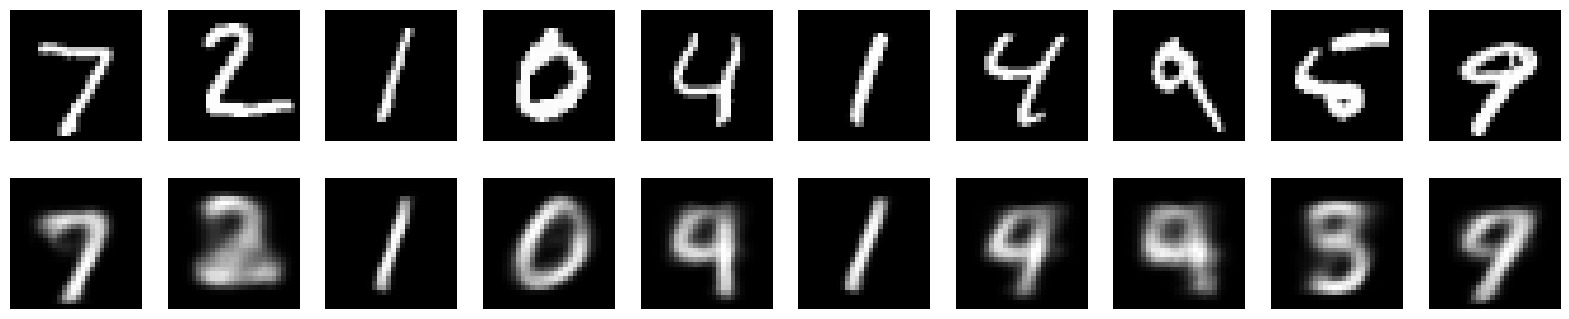

In [ ]:
def plot_reconstructions(model, data, n=10):
    z_mean, z_log_var, z = model.encoder(data[:n])
    reconstructions = model.decoder(z)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)


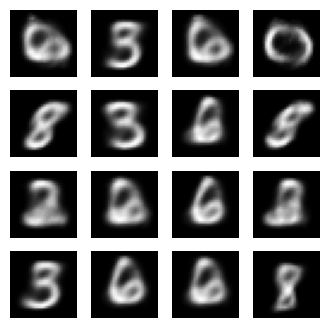

In [ ]:
def generate_samples(decoder, n=16):
    random_latent_vectors = tf.random.normal(shape=(n, latent_dim))
    generated_images = decoder(random_latent_vectors)

    plt.figure(figsize=(4, 4))
    for i in range(n):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i].numpy().reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

generate_samples(decoder)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


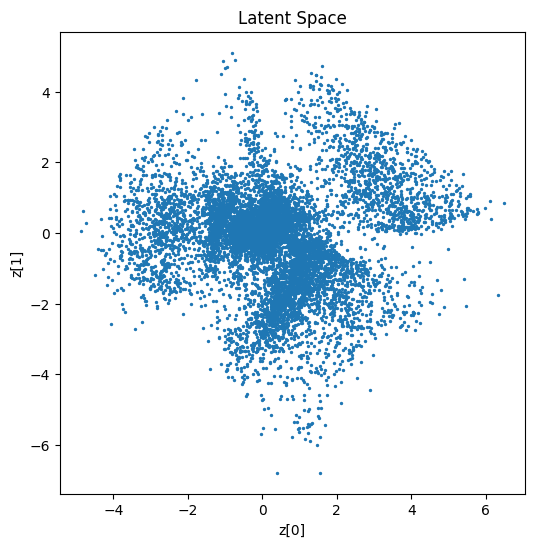

In [ ]:
z_mean, _, _ = encoder.predict(x_test)

plt.figure(figsize=(6, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], s=2)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space")
plt.show()
